# Distances and contacts
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/README.html)

The `MDAnalysis.analysis.distances` module provides functions to rapidly compute distances. These largely take in coordinate arrays.

`MDAnalysis.analysis.contacts` contains functions and a class to analyse the fraction of native contacts over a trajectory.


In [1]:
import warnings

import matplotlib.pyplot as plt
import MDAnalysis as mda

from MDAnalysis.tests.datafiles import PDB_small, PDB_closed
from MDAnalysis.analysis import distances

%matplotlib inline

# suppress some MDAnalysis warnings when writing PDB files
warnings.filterwarnings('ignore')

## Atom-wise distances between matching AtomGroups
The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. ([BDPW09]) AdK has three domains:

* CORE
* LID: an ATP-binding domain (residues 122-159)
* NMP: an AMP-binding domain (residues 30-59)

In [2]:
# loading files
u1 = mda.Universe(PDB_small)   # open AdK
u2 = mda.Universe(PDB_closed)  # closed AdK

### Calculating the distance between CA atoms

In [3]:
# Calculating the distance between CA atoms
ca1 = u1.select_atoms('name CA')
ca2 = u2.select_atoms('name CA')

resids1, resids2, dist = distances.dist(ca1, ca2,
                                        offset=0)  # for residue numbers

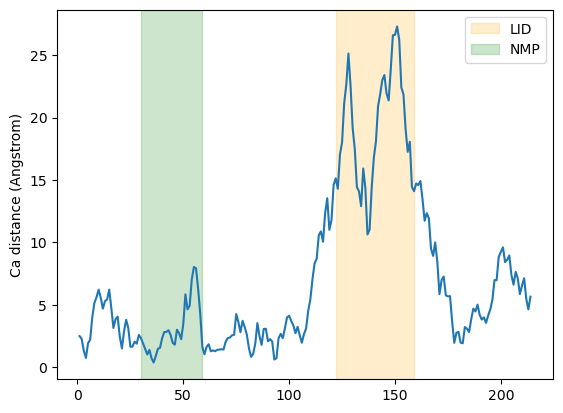

In [4]:
# plotting
plt.plot(resids1, dist)
plt.ylabel('Ca distance (Angstrom)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

### Calculating the distance with periodic boundary conditions
It is common to want to calculate distances with the minimum image convention. To do this, you must pass the unitcell dimensions of the system to the box keyword, even if your Universe has dimensions defined.

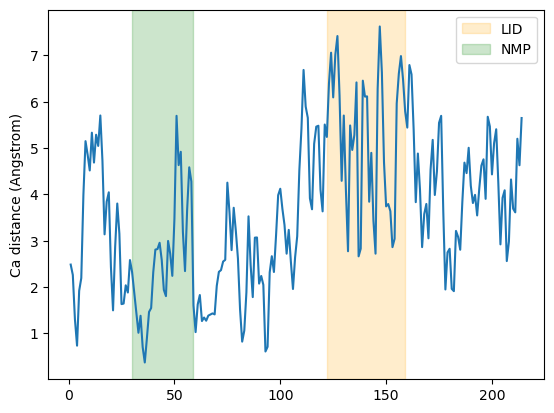

In [5]:
resids1_box, resids2_box, dist_box = distances.dist(ca1, ca2,
                                                    box=[10, 10, 10, 90, 90, 90])

# plotting
plt.plot(resids1_box, dist_box)
plt.ylabel('Ca distance (Angstrom)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

## All distances between two selections

In [6]:
import numpy as np

u = mda.Universe(PDB_small)   # open AdK

### Calculating atom-to-atom distances between non-matching coordinate arrays

In [7]:
# Calculating atom-to-atom distances between non-matching coordinate arrays
LID_ca = u.select_atoms('name CA and resid 122-159')
NMP_ca = u.select_atoms('name CA and resid 30-59')

n_LID = len(LID_ca)
n_NMP = len(NMP_ca)
print('LID has {} residues and NMP has {} residues'.format(n_LID, n_NMP))

LID has 38 residues and NMP has 30 residues


In [8]:
# distances.distance_array will produce an array with shape z distances 
# if there are n positions in the reference array and m positions in the other configuration. 
# If you want to calculate distances following the minimum image convention, 
# you must pass the universe dimensions into the box keyword.

dist_arr = distances.distance_array(LID_ca.positions, # reference
                                    NMP_ca.positions, # configuration
                                    box=u.dimensions)
dist_arr.shape

(38, 30)

Text(0, 0.5, 'Distance (Angstrom)')

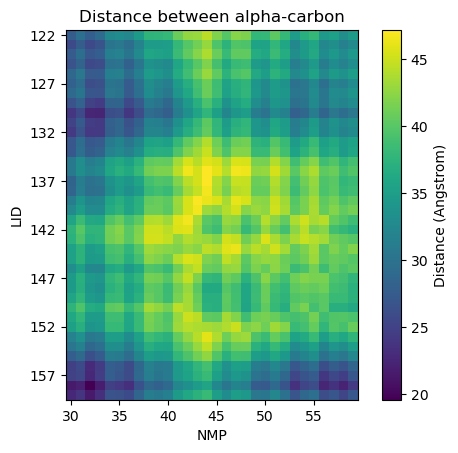

In [9]:
# Plotting distance as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(dist_arr, origin='upper')

# add residue ID labels to axes
tick_interval = 5
ax.set_yticks(np.arange(n_LID)[::tick_interval])
ax.set_xticks(np.arange(n_NMP)[::tick_interval])
ax.set_yticklabels(LID_ca.resids[::tick_interval])
ax.set_xticklabels(NMP_ca.resids[::tick_interval])

# add figure labels and titles
plt.ylabel('LID')
plt.xlabel('NMP')
plt.title('Distance between alpha-carbon')

# colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Distance (Angstrom)')

### Calculating residue-to-residue distances
As `distances.distance_array` just takes coordinate arrays as input, it is very flexible in calculating distances between each atom, or centers-of-masses, centers-of-geometries, and so on.

Instead of calculating the distance between the alpha-carbon of each residue, we could look at the distances between the centers-of-mass instead. The process is very similar to the atom-wise distances above, but we give `distances.distance_array` an array of residue center-of-mass coordinates instead.

In [10]:
LID = u.select_atoms('resid 122-159')
NMP = u.select_atoms('resid 30-59')

LID_com = LID.center_of_mass(compound='residues')
NMP_com = NMP.center_of_mass(compound='residues')

n_LID = len(LID_com)
n_NMP = len(NMP_com)

print('LID has {} residues and NMP has {} residues'.format(n_LID, n_NMP))

LID has 38 residues and NMP has 30 residues


Text(0, 0.5, 'Distance (Angstrom)')

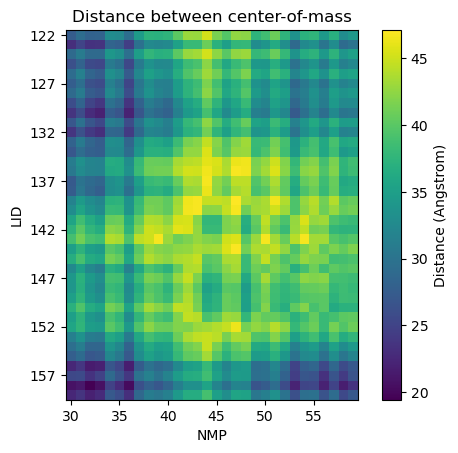

In [11]:
# We can pass these center-of-mass arrays directly into distances.distance_array.
res_dist = distances.distance_array(LID_com, NMP_com, box=u.dimensions)

# plotting
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(res_dist, origin='upper')

# add residue ID labels to axes
tick_interval = 5
ax2.set_yticks(np.arange(n_LID)[::tick_interval])
ax2.set_xticks(np.arange(n_NMP)[::tick_interval])
ax2.set_yticklabels(LID.residues.resids[::tick_interval])
ax2.set_xticklabels(NMP.residues.resids[::tick_interval])

# add figure labels and titles
plt.ylabel('LID')
plt.xlabel('NMP')
plt.title('Distance between center-of-mass')

# colorbar
cbar2 = fig2.colorbar(im2)
cbar2.ax.set_ylabel('Distance (Angstrom)')


## All distances within a selection

In [12]:
# loading files
u = mda.Universe(PDB_small)

### Calculating atom-wise distances

In [13]:
# calculating atom-wise distances
ca = u.select_atoms('name CA')
n_ca = len(ca)
print(n_ca)

self_distances = distances.self_distance_array(ca.positions)
print(self_distances.shape)

214
(22791,)


In [14]:
# We can convert this into a more easily interpreted square distance array. 
# First we create an all-zero square array and get the indices of the upper and lower triangular matrices.
sq_dist_arr = np.zeros((n_ca, n_ca))
triu = np.triu_indices_from(sq_dist_arr, k=1)

# Then we simply assign the calculated distances to the upper and lower triangular positions.
sq_dist_arr[triu] = self_distances
sq_dist_arr.T[triu] = self_distances


Text(0, 0.5, 'Distance (Angstrom)')

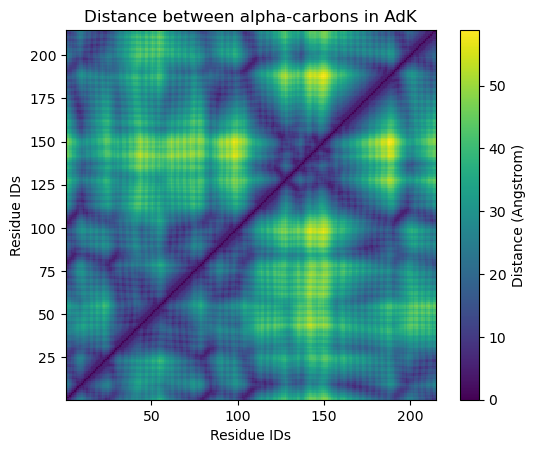

In [15]:
# plotting
fig, ax = plt.subplots()
im = ax.pcolor(ca.resids, ca.resids, sq_dist_arr)

# plt.pcolor gives a rectangular grid by default
# so we need to make our heatmap square
ax.set_aspect('equal')

# add figure labels and titles
plt.ylabel('Residue IDs')
plt.xlabel('Residue IDs')
plt.title('Distance between alpha-carbons in AdK')

# colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Distance (Angstrom)')

### Calculating distances for each residue
Instead of calculating the distance between the alpha-carbon of each residue, we could look at the distances between the centers-of-mass instead. The process is very similar to the atom-wise distances above, but we have to pass `distances.self_distance_array` an array of residue center-of-mass coordinates instead.

In [16]:
res_com = u.atoms.center_of_mass(compound='residues')
n_res = len(res_com)
print(n_res)

res_dist = distances.self_distance_array(res_com)
print(res_dist.shape)

214
(22791,)


In [17]:
sq_dist_res = np.zeros((n_res, n_res))
sq_dist_res[triu] = res_dist
sq_dist_res.T[triu] = res_dist

Text(0, 0.5, 'Distance (Angstrom)')

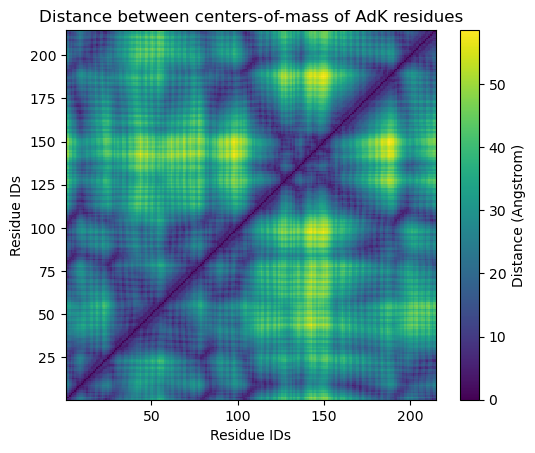

In [18]:
# plotting
fig2, ax2 = plt.subplots()
im2 = ax2.pcolor(u.residues.resids, u.residues.resids, sq_dist_res)

# plt.pcolor gives a rectangular grid by default
# so we need to make our heatmap square
ax2.set_aspect('equal')

# add figure labels and titles
plt.ylabel('Residue IDs')
plt.xlabel('Residue IDs')
plt.title('Distance between centers-of-mass of AdK residues')

# colorbar
cbar2 = fig2.colorbar(im2)
cbar2.ax.set_ylabel('Distance (Angstrom)')

## Fraction of native contacts over a trajectory
Here, we calculate the native contacts of a trajectory as a fraction of the native contacts in a given reference.

**Residues can be determined to be in contact if atoms from the two residues are within a certain distance.** Native contacts are those contacts that exist within a native state, as opposed to non-native contacts, which are formed along the path to a folded state or during the transition between two conformational states. MDAnalysis defines native contacts as those present in the reference structure (`refgroup`) given to the analysis.

In [19]:
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts
import pandas as pd

# loading files
u = mda.Universe(PSF, DCD)

In [20]:
# Defining the groups for conatact analysis
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

### Hard cutoff with a single reference

In [21]:
# Hard cutoff with a single reference
# Two residues are in contact 
# if the distance between them is lower than or equal to the distance in the reference structure.
ca1 = contacts.Contacts(u,
                        select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='hard_cut').run()

In [22]:
ca1_df = pd.DataFrame(ca1.results.timeseries,
                      columns=['Frame',
                               'Contacts from first frame'])
ca1_df.head()
# Note that the data is presented as fractions of the native contacts present in the reference configuration. 
# In order to find the number of contacts present, multiply the data with the number of contacts 
# in the reference configuration. 
# Initial contact matrices are saved as pairwise arrays in ca1.initial_contacts.

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.492754
2,2.0,0.449275
3,3.0,0.507246
4,4.0,0.463768


In [23]:
ca1.initial_contacts[0].shape

(70, 44)

In [24]:
n_ref = ca1.initial_contacts[0].sum()
print('There are {} contacts in the reference.'.format(n_ref))

There are 69 contacts in the reference.


In [25]:
n_contacts = ca1.results.timeseries[:, 1] * n_ref
print(n_contacts[:5])

[69. 34. 31. 35. 32.]


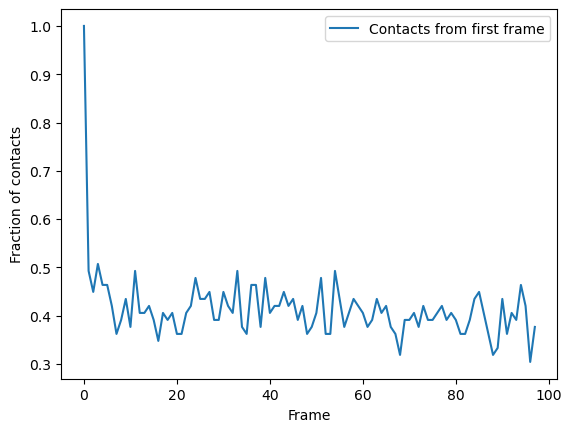

In [26]:
ca1_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')
plt.show()

# In this trajectory, the fraction of native contats drops immediately to under 50%, 
# and fluctuates around 40% for the rest of the simulation. 
# This means that the protein retains a structure where around 40% salt bridges in the reference 
# remain within the distance of the reference. 
# However, it is difficult to infer information on domain rearrangements and other large-scale movement, 
# other than that the the protein never returns to a similar state as the initial frame.

### Radius cutoff
Another metric that MDAnalysis supports is determining residues to be in contact if they are within a certain radius. This is similar to the hard cutoff metric, in that there is no potential. The difference is that a single radius is used as the cutoff for all contacts, rather than the distance between the residues in the reference. For a tutorial on similar contact analysis of residues within a cutoff. That tutorial is for calculating the overall number or fraction of contacts, instead of the fraction of native contacts.

You can choose this method by passing in the method name `radius_cut`, which uses the `radius_cut_q()`. The `radius` keyword specifies the distance used in ångström. No other arguments need to passed into `kwargs`.

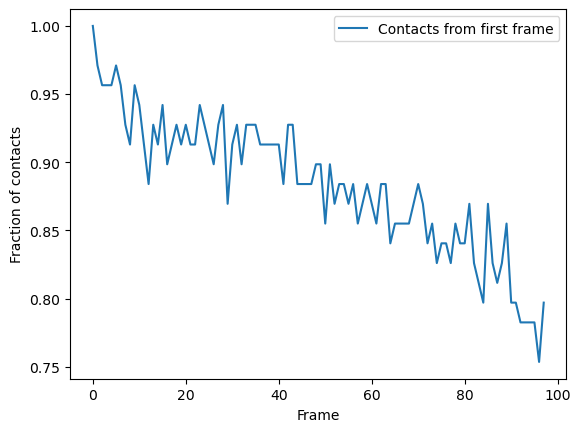

In [27]:
ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

# plotting
ca2_df = pd.DataFrame(ca2.results.timeseries,
                      columns=['Frame', 'Contacts from first frame'])
ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')
plt.show()

### Soft cutoff and multiple references
`refgroup` can either be two contacting groups in a reference configuration, or a list of tuples of two contacting groups.

Below we want to look at native contacts from the first frame, and the last frame. To do this, we create a new universe called `ref` with the same files (and therefore same data) as `u`. We need to do this so that the (`acidic`, `basic`) selections from `u`, which are assigned from the first frame, remain unchanged. `ref` is a different Universe so when we set it to its last frame (with index `-1`), it does not affect `u` or the previous selections. Now, when we re-select the atomgroups from `ref` with the selection string used in the hard-cutoff section, different contacts are selected to the contacts found in the first frame of `u`.



In [28]:
ref = mda.Universe(PSF, DCD)

ref.trajectory[-1]
acidic_2 = ref.select_atoms(sel_acidic)
basic_2 = ref.select_atoms(sel_basic)

In [29]:
# Soft cutoff
ca3 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=[(acidic, basic), (acidic_2, basic_2)],
                        radius=4.5,
                        method='soft_cut',
                        kwargs={'beta': 5.0,
                                'lambda_constant': 1.5}).run()

ca3_df = pd.DataFrame(ca3.results.timeseries,
                      columns=['Frame',
                               'Contacts from first frame',
                               'Contacts from last frame'])
ca3_df.head()

,Frame,Contacts from first frame,Contacts from last frame
0,0.0,0.999094,0.719242
1,1.0,0.984928,0.767501
2,2.0,0.984544,0.788027
3,3.0,0.970184,0.829219
4,4.0,0.980425,0.833500


Again, we can see that the fraction of native contacts from the first frame has a very different shape for the `soft_cut` method vs the other methods. Like the `radius_cut` method, a gradual decrease in salt bridges is visible; unlike that plot, however, more than 80% native contacts are counted by 100 frames using this metric. By itself, this analysis might suggest that the protein is unfolding.

More interesting is the fraction of native contacts from the last frame, which rises from ~70% to 100% over the simulation. This rise indicates that the protein is not unfolding, per se (where contacts from the last frame would be expected to rise much less); but instead, a rearrangement of the domains is occurring, where new contacts are formed in the final state.

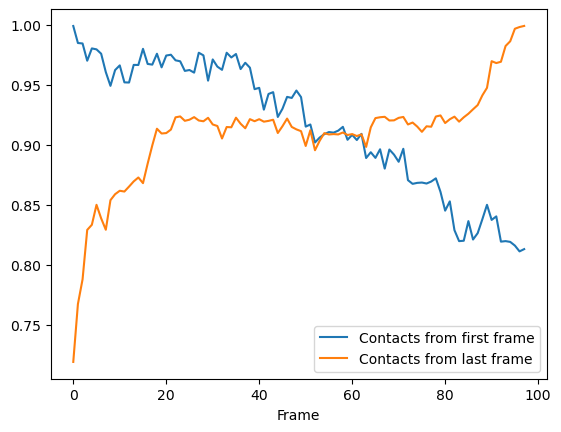

In [30]:
# plotting
ca3_df.plot(x='Frame')
plt.show()

In [31]:
import nglview as nv

# Indeed, viewing the trajectory shows us that the enzyme transitions from a closed to open state.

u.trajectory[0]  # set trajectory to first frame (closed)
adk_closed = mda.Merge(u.atoms).load_new(u.atoms.positions) # make a new Universe with coordinates of first frame

adk_closed_view = nv.show_mdanalysis(adk_closed)
adk_closed_view

NGLWidget()

In [32]:
u.trajectory[-1]  # set trajectory to last frame (open)
# make a new Universe with coordinates of last frame
adk_open = mda.Merge(u.atoms).load_new(u.atoms.positions)

adk_open_view = nv.show_mdanalysis(adk_open)
adk_open_view

NGLWidget()

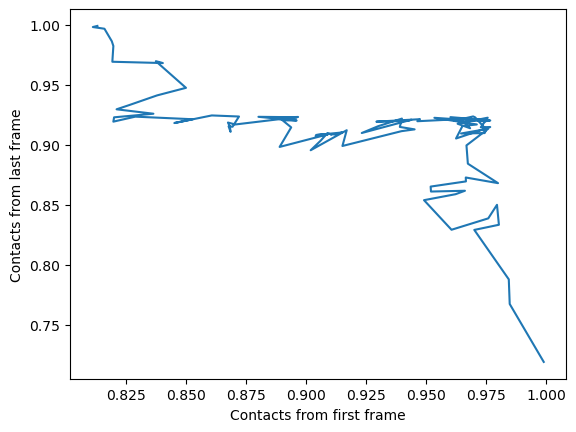

In [33]:
ca3_df.plot(x='Contacts from first frame',
            y='Contacts from last frame',
            legend=False)
plt.ylabel('Contacts from last frame')
plt.show()

## Q1 vs Q2 contact analysis
Here we calculate a Q1 vs Q2 plot, where Q1 refers to fraction of native contacts along a trajectory with reference to the first frame, and Q2 represents the fraction of native contacts with reference to the last.

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. ([BDPW09]) The trajectory DCD samples a transition from a closed to an open conformation.

In [34]:
# loading files
u = mda.Universe(PSF, DCD)

In [35]:
# Calculating Q1 vs Q2
# We choose to calculate contacts for all the alpha-carbons in the protein, and 
# define the contact radius cutoff at 8 Angstrom. contacts.q1q2 returns a contacts.Contacts object, 
# which we can run directly.
q1q2 = contacts.q1q2(u, 'name CA', radius=8).run()

q1q2_df = pd.DataFrame(q1q2.results.timeseries,
                       columns=['Frame',
                                'Q1',
                                'Q2'])
q1q2_df.head()

,Frame,Q1,Q2
0,0.0,1.000000,0.946494
1,1.0,0.980926,0.949262
2,2.0,0.973660,0.952952
3,3.0,0.972752,0.951107
4,4.0,0.970027,0.948339


Text(0, 0.5, 'Fraction of native contacts')

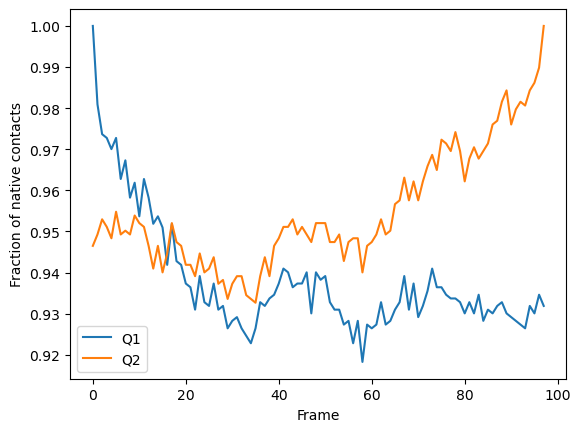

In [36]:
# plotting
q1q2_df.plot(x='Frame')
plt.ylabel('Fraction of native contacts')

Text(0, 0.5, 'Q2')

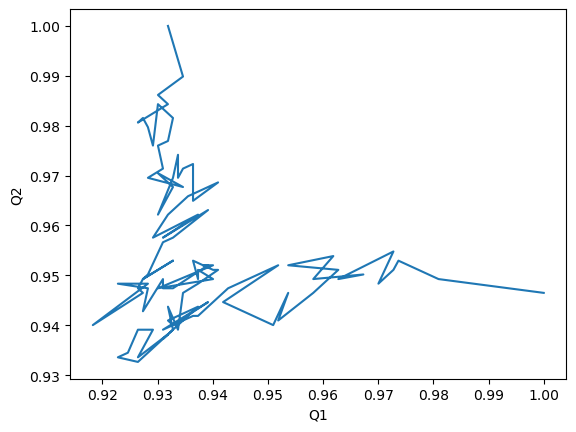

In [37]:
q1q2_df.plot(x='Q1', y='Q2', legend=False)
plt.ylabel('Q2')

## Contact analysis: number of contacts within a cutoff
We calculate the number of salt bridges in an enzyme as it transitions from a closed to an open conformation.

Quantifying the number of contacts over a trajectory can give insight into the formation and rearrangements of secondary and tertiary structure. This is closely related to native contacts analysis; where the fraction of native contacts refers to the fraction of contacts retained by a protein from the contacts in a reference frame, the number of contacts simply counts how many residues are within a certain cutoff for each frame. No reference is necessary.

In [38]:
# loading files
u = mda.Universe(PSF, DCD)

We define salt bridges as contacts between NH/NZ in ARG/LYS and OE*/OD* in ASP/GLU. It is not recommend to use this overly simplistic definition for real work that you want to publish.

In [39]:
# defining the groups for conatact analysis
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

In [40]:
# Calculating number of contacts within a cutoff

def contacts_within_cutoff(u, group_a, group_b, radius=4.5):
    timeseries = []
    for ts in u.trajectory:
        # calculate distances between group_a and group_b
        dist = contacts.distance_array(group_a.positions, group_b.positions)
        # determine which distances <= radius
        n_contacts = contacts.contact_matrix(dist, radius).sum()
        timeseries.append([ts.frame, n_contacts])
    return np.array(timeseries)

In [41]:
ca = contacts_within_cutoff(u, acidic, basic, radius=4.5)
ca.shape

(98, 2)

In [42]:
ca_df = pd.DataFrame(ca, columns=['Frame',
                                  '# Contacts'])
ca_df.head()

,Frame,# Contacts
0,0,69
1,1,73
2,2,77
3,3,77
4,4,85


Text(0, 0.5, '# salt bridges')

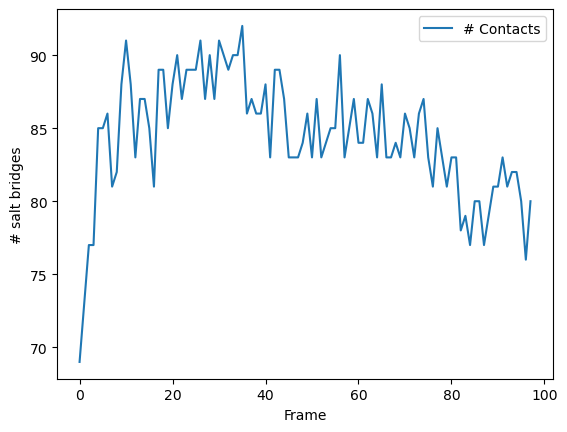

In [43]:
# plotting
ca_df.plot(x='Frame')
plt.ylabel('# salt bridges')

## Write your own native contacts analysis method

In [44]:
# Loading files
u = mda.Universe(PSF, DCD)

# Defining the groups for conatact analysis
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

In [45]:
# Define your own function
# Any function you define must have r and r0 as its first and second arguments respectively, 
# even if you don’t necessarily use them.
# r: an array of distances between atoms at the current time
# r0: an array of distances between atoms in the reference

def fraction_contacts_between(r, r0, radius=3.4, min_radius=2.5):
    is_in_contact = (r < radius) & (r > min_radius)  # array of bools
    fraction = is_in_contact.sum()/r.size
    return fraction

In [46]:
# We pass fraction_contacts_between to the contacts.Contacts class
# Keyword arguments for our custom function must be in the kwargs dictionary. 
ca = contacts.Contacts(u,
                       select=(sel_acidic, sel_basic),
                       refgroup=(acidic, basic),
                       method=fraction_contacts_between,
                       radius=5.0,
                       kwargs={'radius': 5.0,
                               'min_radius': 2.4}).run()

In [47]:
ca_df = pd.DataFrame(ca.results.timeseries,
                    columns=['Frame',
                             'Contacts from first frame'])
ca_df.head()

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.988764
2,2.0,0.943820
3,3.0,0.943820
4,4.0,0.943820


<Axes: xlabel='Frame'>

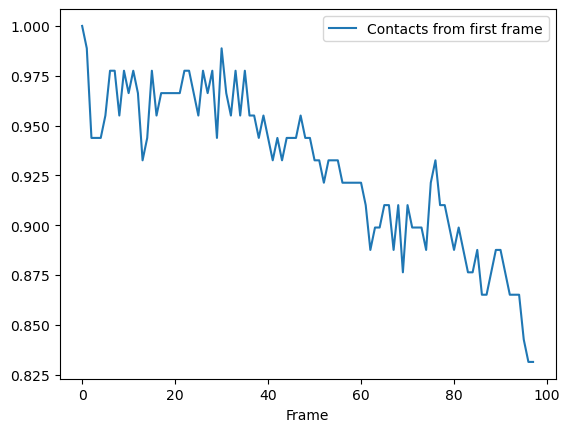

In [48]:
# plotting
ca_df.plot(x='Frame')